# Analysing Performance of Stocks using Causal Discovery

## Setup

Import the datasets:

In [426]:
%%capture


UsageError: %%capture is a cell magic, but the cell body is empty.


## Data Loading

In [427]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [428]:
data_dir = "C:/Users/diego/iCloudDrive/Documents/MBZUAI Sem/Semester 2/ML703 Probabilistic and Statistical Inference/Project/JN/Datasets/"

company = pd.read_csv(data_dir + "Company.csv")
companyValues = pd.read_csv(data_dir + "CompanyValues.csv")
companyTweet = pd.read_csv(data_dir + "Company_Tweet.csv")
tweet = pd.read_csv(data_dir + "Tweet.csv")
tweet = tweet.merge(companyTweet, on="tweet_id", how='inner')

In [429]:
company.ticker_symbol.unique()

array(['AAPL', 'GOOG', 'GOOGL', 'AMZN', 'TSLA', 'MSFT'], dtype=object)

In [430]:
companyValues.head()

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
0,AAPL,2020-05-29,317.94,38399530,319.25,321.15,316.47
1,AAPL,2020-05-28,318.25,33449100,316.77,323.44,315.63
2,AAPL,2020-05-27,318.11,28236270,316.14,318.71,313.09
3,AAPL,2020-05-26,316.73,31380450,323.50,324.24,316.50
4,AAPL,2020-05-22,318.89,20450750,315.77,319.23,315.35


In [431]:
companyValuesTesla = companyValues[companyValues.ticker_symbol == 'TSLA']
tweetTesla = tweet[tweet.ticker_symbol == 'TSLA']

In [432]:
companyValuesTesla.shape

(3065, 7)

In [433]:
tweetTesla.shape

(1096868, 8)

In [434]:
from datetime import datetime, timezone
# from zoneinfo import ZoneInfo

tweetTesla['post_date'] =  pd.to_datetime(tweetTesla['post_date'], unit='s', utc=True)
tweetTesla['post_datetime'] = tweetTesla['post_date'].dt.tz_convert('Asia/Qatar')
tweetTesla['date'] = tweetTesla['post_datetime'].dt.date

tweetTesla[tweetTesla.writer == "btcgemini"]

C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,post_datetime,date


In [435]:
tweetTeslaMetrics = tweetTesla[['date', 'comment_num', 'retweet_num', 'like_num']]
tweetTeslaMetrics = tweetTeslaMetrics.groupby(["date"]).sum()
tweetTeslaMetrics2019 = tweetTeslaMetrics[(tweetTeslaMetrics.index >= pd.to_datetime("2018/12/25")) & (tweetTeslaMetrics.index <= pd.to_datetime("2019/12/31"))]
tweetTeslaMetrics2019

C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,comment_num,retweet_num,like_num
date,,,
2018-12-25,432,354,3395
2018-12-26,602,815,5048
2018-12-27,778,709,5513
2018-12-28,1184,1703,11564
2018-12-29,777,866,5093
...,...,...,...
2019-12-27,1464,1852,12774
2019-12-28,780,1448,6924
2019-12-29,663,815,6225


In [436]:
tweetTeslaMetrics2019['log_retweet_num'] = np.log(tweetTeslaMetrics2019['retweet_num'])
tweetTeslaMetrics2019['log_comment_num'] = np.log(tweetTeslaMetrics2019['comment_num'])

C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [437]:
from sklearn.linear_model import LinearRegression

X = [i for i in range(0, len(tweetTeslaMetrics2019.log_comment_num))]
X = np.reshape(X, (len(X), 1))
y = tweetTeslaMetrics2019.log_comment_num

lr_model = LinearRegression()
lr_model.fit(X, y)

trend = lr_model.predict(X)

tweetTeslaMetrics2019['detrended_log_comment_num'] = [y[i]-trend[i] for i in range(0, len(tweetTeslaMetrics2019.log_comment_num))]

C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [438]:
lag_days = 1

# temp = np.diff(tweetTeslaMetrics2019['log_retweet_num'], n=lag_days)
# temp_2 = np.diff(tweetTeslaMetrics2019['detrended_log_comment_num'], n=lag_days)

tweetTeslaMetrics2019 = tweetTeslaMetrics2019[-365:]
# tweetTeslaMetrics2019['lag_log_retweet_num'] = temp
# tweetTeslaMetrics2019['lag_detrended_log_comment_num'] = temp_2

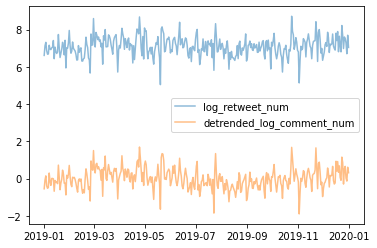

In [439]:
plt.plot(tweetTeslaMetrics2019.log_retweet_num, alpha=0.5, label="log_retweet_num")
plt.plot(tweetTeslaMetrics2019.detrended_log_comment_num, alpha=0.5, label="detrended_log_comment_num")
plt.legend()

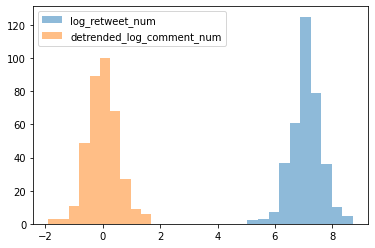

In [440]:
plt.hist(tweetTeslaMetrics2019.log_retweet_num, alpha=0.5, label="log_retweet_num")
plt.hist(tweetTeslaMetrics2019.detrended_log_comment_num, alpha=0.5, label="detrended_log_comment_num")
plt.legend()

In [443]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(tweetTeslaMetrics2019.log_retweet_num)
print('Log Retweet Number test:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

result = adfuller(tweetTeslaMetrics2019.detrended_log_comment_num)
print('Detrended Log Tweet Comment Number test:')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

Log Retweet Number test:
ADF Statistic: -3.677427
p-value: 0.004442
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
Detrended Log Tweet Comment Number test:
ADF Statistic: -2.804106
p-value: 0.057690
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [444]:
companyValuesTesla['date'] = pd.to_datetime(companyValuesTesla['day_date']).dt.date
companyValuesTeslaMetrics = companyValuesTesla[['date', 'close_value', 'volume', 'open_value', 'high_value', 'low_value']]
companyValuesTeslaMetrics = companyValuesTeslaMetrics.groupby(['date']).sum()
companyValuesTeslaMetrics2019 = companyValuesTeslaMetrics[(companyValuesTeslaMetrics.index >= pd.to_datetime("2018/12/25")) & (companyValuesTeslaMetrics.index <= pd.to_datetime("2019/12/31"))]
companyValuesTeslaMetrics2019

C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


,close_value,volume,open_value,high_value,low_value
date,,,,,
2018-12-25,295.39,5559913,313.50,314.5000,295.1950
2018-12-26,326.09,8143102,300.00,326.9700,294.0900
2018-12-27,316.13,8567385,319.84,322.1717,301.5000
2018-12-28,333.87,9918777,323.10,336.2400,318.4100
2018-12-29,333.87,9918777,323.10,336.2400,318.4100
...,...,...,...,...,...
2019-12-27,430.38,9956827,435.00,435.3100,426.1100
2019-12-28,430.38,9956827,435.00,435.3100,426.1100
2019-12-29,430.38,9956827,435.00,435.3100,426.1100


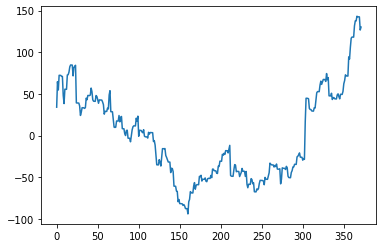

In [445]:
from sklearn.linear_model import LinearRegression

X = [i for i in range(0, len(companyValuesTeslaMetrics2019.close_value))]
X = np.reshape(X, (len(X), 1))
y = companyValuesTeslaMetrics2019.close_value

lr_model = LinearRegression()
lr_model.fit(X, y)

trend = lr_model.predict(X)

detrended = [y[i]-trend[i] for i in range(0, len(companyValuesTeslaMetrics2019.close_value))]

plt.plot(detrended)

C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


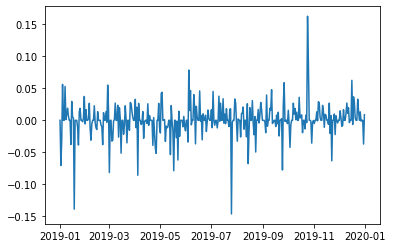

In [446]:
lag_days = 1

companyValuesTeslaMetrics2019['log_close_value'] = np.log(companyValuesTeslaMetrics2019['close_value'])
temp = np.diff(companyValuesTeslaMetrics2019['log_close_value'], n=lag_days)
companyValuesTeslaMetrics2019 = companyValuesTeslaMetrics2019[-365:]
companyValuesTeslaMetrics2019['lag_log_close_value'] = temp[-365:]
plt.plot(companyValuesTeslaMetrics2019.lag_log_close_value)

(array([  2.,   1.,   8.,  28., 227.,  83.,  13.,   2.,   0.,   1.]),
 array([-0.14634122, -0.11543636, -0.0845315 , -0.05362664, -0.02272178,
         0.00818308,  0.03908794,  0.0699928 ,  0.10089766,  0.13180252,
         0.16270738]),
 <BarContainer object of 10 artists>)

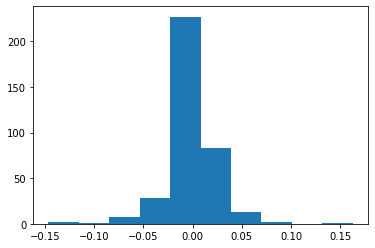

In [447]:
plt.hist(companyValuesTeslaMetrics2019.lag_log_close_value)

In [448]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(companyValuesTeslaMetrics2019.lag_log_close_value)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.635766
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


In [449]:
data = np.column_stack((companyValuesTeslaMetrics2019.lag_log_close_value,
                    tweetTeslaMetrics2019.log_retweet_num,
                    tweetTeslaMetrics2019.detrended_log_comment_num))
data[:5]

array([[ 0.        ,  6.61204103, -0.54695628],
       [-0.07058239,  7.12849595, -0.07861812],
       [-0.03197756,  7.31388683,  0.14831061],
       [ 0.05609431,  6.87005341, -0.38452907],
       [ 0.        ,  6.67708346, -0.51965665]])

## Causal Discovery

In [450]:
# Imports

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb

In [451]:
# Initialize dataframe object, specify time axis and variable names
var_names = [r'$X^0$', r'$Y^0$', r'$Y^1$']
dataframe = pp.DataFrame(data, 
                         datatime = np.arange(len(data)), 
                         var_names=var_names)

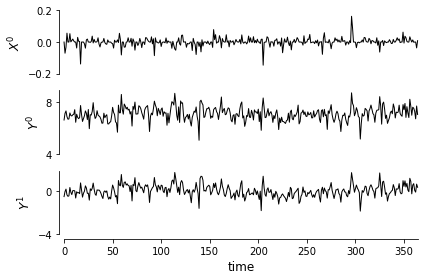

In [452]:
tp.plot_timeseries(dataframe); plt.show()

In [453]:
parcorr = ParCorr(significance='analytic')

pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 28


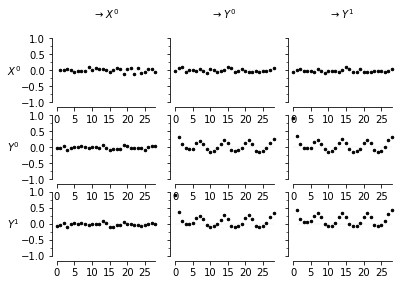

In [454]:
correlations = pcmci.get_lagged_dependencies(tau_max=28, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

In [455]:
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci_gpdc = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=gpdc,
    verbosity=0)

In [456]:
results = pcmci_gpdc.run_pcmci(tau_max=8, pc_alpha=0.5)
pcmci_gpdc.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)

C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\sklearn\gaussian_process\kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\sklearn\gaussian_process\kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
C:\Users\diego\anaconda3\envs\tigramite\lib\site-packages\sklearn\gaussian_process\kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
C:\Users\diego\anaconda3\envs


## Significant links at alpha = 0.01:

    Variable $X^0$ has 4 link(s):
        ($Y^1$  0): pval = 0.00000 | val =  0.216
        ($Y^0$  0): pval = 0.00100 | val =  0.172
        ($X^0$ -7): pval = 0.00300 | val =  0.162
        ($Y^1$ -7): pval = 0.00900 | val =  0.151

    Variable $Y^0$ has 3 link(s):
        ($Y^1$  0): pval = 0.00000 | val =  0.811
        ($X^0$  0): pval = 0.00100 | val =  0.172
        ($X^0$ -1): pval = 0.00300 | val =  0.164

    Variable $Y^1$ has 4 link(s):
        ($Y^0$  0): pval = 0.00000 | val =  0.811
        ($Y^1$ -1): pval = 0.00000 | val =  0.372
        ($X^0$  0): pval = 0.00000 | val =  0.216
        ($Y^1$ -7): pval = 0.00000 | val =  0.178


In [457]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=8, fdr_method='fdr_bh')
pcmci.print_significant_links(
        p_matrix = results['p_matrix'], 
        q_matrix = q_matrix,
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


## Significant links at alpha = 0.01:

    Variable $X^0$ has 2 link(s):
        ($Y^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.216
        ($Y^0$  0): pval = 0.00100 | qval = 0.00100 | val =  0.172

    Variable $Y^0$ has 2 link(s):
        ($Y^1$  0): pval = 0.00000 | qval = 0.00000 | val =  0.811
        ($X^0$  0): pval = 0.00100 | qval = 0.00100 | val =  0.172

    Variable $Y^1$ has 4 link(s):
        ($Y^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.811
        ($Y^1$ -1): pval = 0.00000 | qval = 0.00000 | val =  0.372
        ($X^0$  0): pval = 0.00000 | qval = 0.00000 | val =  0.216
        ($Y^1$ -7): pval = 0.00000 | qval = 0.00000 | val =  0.178


In [458]:
link_matrix = pcmci.return_significant_links(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

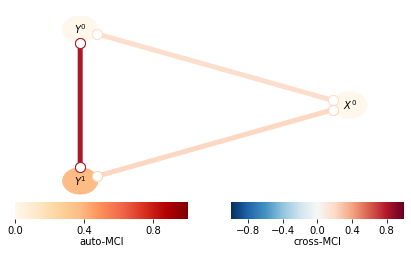

In [459]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

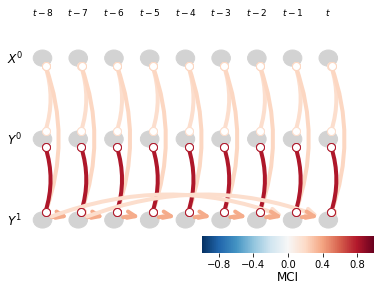

In [460]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

### CMIknn

In [414]:
cmi_knn = CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks')
pcmci_cmi_knn = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=cmi_knn,
    verbosity=2)
results = pcmci_cmi_knn.run_pcmci(tau_max=2, pc_alpha=0.05)
pcmci_cmi_knn.print_significant_links(
        p_matrix = results['p_matrix'], 
        val_matrix = results['val_matrix'],
        alpha_level = 0.01)


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 2
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Variable $X^0$

Iterating through pc_alpha = [0.05]:

# pc_alpha = 0.05 (1/1):

Testing condition sets of dimension 0:

    Link ($X^0$ -1) --> $X^0$ (1/6):
    Subset 0: () gives pval = 0.00000 / val =  0.675
    No conditions of dimension 0 left.

    Link ($X^0$ -2) --> $X^0$ (2/6):
    Subset 0: () gives pval = 0.00000 / val =  0.198
    No conditions of dimension 0 left.

    Link ($Y^0$ -1) --> $X^0$ (3/6):
    Subset 0: () gives pval = 0.36400 / val =  0.011
    Non-significance detected.

    Link ($Y^0$ -2) --> $X^0$ (4/6):
    Subset 0: () gives pval = 0.10400 / val =  0.020
    Non-significance detected.

    Link ($Y^1$ -1) --> $X^0$ (5/6):
    Subset 0: () gives pval = 0.80900 / val =  0.001
    Non-significance detected.

    Link ($Y^1$ -2) --> $X^0$ (6/6):
    Subset 0: () gives pval = 0

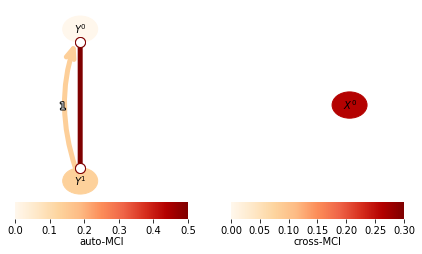

In [415]:
link_matrix = pcmci_cmi_knn.return_significant_links(pq_matrix=results['p_matrix'],
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']
tp.plot_graph(
    val_matrix=results['val_matrix'],
    link_matrix=link_matrix,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    vmin_edges=0.,
    vmax_edges = 0.3,
    edge_ticks=0.05,
    cmap_edges='OrRd',
    vmin_nodes=0,
    vmax_nodes=.5,
    node_ticks=.1,
    cmap_nodes='OrRd',
    ); plt.show()